# Лабораторная работа №3

Классификация изображений. Сверточные сети. Предобученные
сверточные сети.

# Подготовка среды

In [ ]:
# установим kaggle
%pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [3]:
# скачаем датасет
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Admin\.cache\kagglehub\datasets\alxmamaev\flowers-recognition\versions\2


# Подготовка датасета

In [2]:
seed = 7


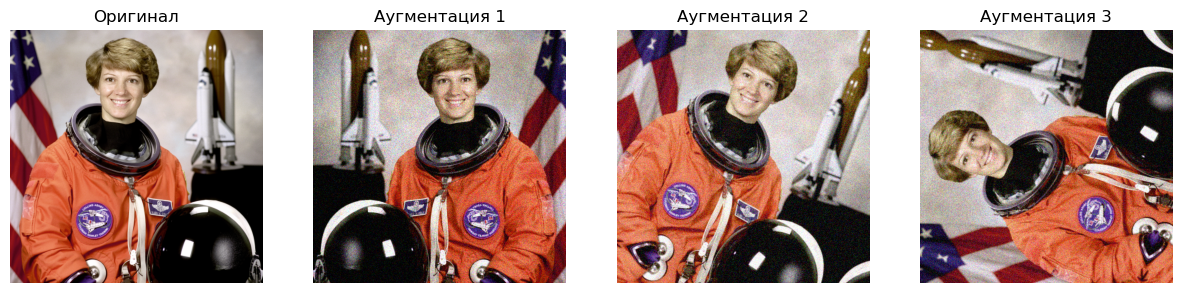

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, transform, exposure, util

# Загрузим тестовое изображение
image = data.astronaut()

np.random.seed = seed

def augment_image(img: np.ndarray):
    """Аугментировать изображение (сделать другое преобразованиями)"""
    # поворот
    angle = np.random.uniform(-90, 90)
    rotated = transform.rotate(img, angle, mode='reflect')
    
    # отражение
    if np.random.rand() > 0.5:
        rotated = np.fliplr(rotated)
    
    # шум
    noised = util.random_noise(rotated, mode='gaussian', var=0.01)
    
    augmented: np.ndarray
    # яркость
    gamma_val = np.random.uniform(0.7, 1.3)
    augmented = exposure.adjust_gamma(noised, gamma=gamma_val)
    
    return augmented

# тест
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title("Оригинал")

for i in range(1, 4):
    axes[i].imshow(augment_image(image))
    axes[i].set_title(f"Аугментация {i}")

for ax in axes:
    ax.axis('off')
plt.show()

In [43]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from sklearn.datasets import load_files


def prepare_dataset_1():
    """Подготовить датасет с картинками"""

    # Загружаем имена файлов и их классы
    data_dir = path + "\\flowers"
    data = load_files(data_dir, load_content=False)

    # Обрабатываем фотографии
    X = []
    y = []
    
    for (file_path, target) in zip(data.filenames, data.target):
        img = imread(file_path)          
        img_resized = resize(img, (224, 224)) 
        X.append(img_resized.flatten()) 
        y.append(target)

        # аугментируем фотографию
        img_augumented = augment_image(img_resized)
        X.append(img_augumented.flatten())
        y.append(target)       

    return X, y

np.random.seed=seed
X, y = prepare_dataset_1()


NameError: name 'augment_image' is not defined

In [54]:
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf

data_dir = path + "\\flowers"

# читаем датасет из папки: тренировочный и валидационный
train_ds, val_ds = image_dataset_from_directory(
    data_dir,
    image_size=(150, 150),
    batch_size=32, # пакеты по 32 изображения - мини-пакетное обучение
    label_mode='categorical',
    validation_split=0.2, # 20% под валидационный датасет
    subset="both",
    seed=seed
)

batches = tf.data.experimental.cardinality(val_ds)

# разделяем валидационный датасет на тестовый и валидационный)
test_ds = val_ds.take(batches // 2)
val_ds = val_ds.skip(batches // 2)

print(f"{tf.data.experimental.cardinality(val_ds).numpy()} for validation")
print(f"{tf.data.experimental.cardinality(test_ds).numpy()} for test")


Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Using 863 files for validation.
14 for validation
13 for test


In [13]:
for x,y in test_ds:
    break
first_x= x[0][:][:][0]
first_y = y[0]

# 1. Обучение Conv2D и MaxPooling

## Сборка модели

In [ ]:
import tensorflow as tf
from keras import layers, models, regularizers, optimizers

# количество классов
num_classes = 5

regularizer = regularizers.l1(0.0001)
#regularizer = None

model = models.Sequential([
    # входные изображения
    layers.Input(shape=(150, 150, 3)),    
    
    # аугментация (должно работать только при обучении)
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),

    # нормализация - пиксели по каждому из цветов занимают байт. приводим к диапазону [0,1]
    layers.Rescaling(1./255),

    # Conv2D + MaxPooling2D
    layers.Conv2D(32, (3, 3), activation='relu', padding="same",
                  kernel_regularizer=regularizer),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding="same",
                  kernel_regularizer=regularizer),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(96, (3, 3), activation='relu', padding="same",
                  kernel_regularizer=regularizer),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(96, (3, 3), activation='relu', padding="same",
                  kernel_regularizer=regularizer),
    layers.MaxPooling2D((2, 2)),

    # полносвязные слои для получения классификации
    layers.Flatten(),
    layers.Dense(512, activation='relu', 
                 kernel_regularizer=regularizer),
    # layers.Dense(32, activation='relu', 
    #              kernel_regularizer=regularizer),
    #layers.Dropout(0.5), # Хорошая практика вместе с L1
    
    # Выходной слой для многоклассовой классификации
    layers.Dense(num_classes, activation='softmax') 
])

# 4. Компиляция
model.compile(
    optimizer=optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_13 (RandomFlip)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_16              │ (None, 150, 150, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_13 (RandomZoom)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness_15            │ (None, 150, 150, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_18 (Rescaling)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 37, 37, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 18, 18, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 18, 18, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 9, 9, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 7776)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 512)            │     3,981,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,142,213 (15.80 MB)

 Trainable params: 4,142,213 (15.80 MB)

 Non-trainable params: 0 (0.00 B)

## Обучение модели

In [65]:
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    #steps_per_epoch=50,
    epochs=100)

Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 46s 384ms/step - accuracy: 0.4140 - loss: 2.5259 - val_accuracy: 0.4116 - val_loss: 1.7896
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 43s 395ms/step - accuracy: 0.4997 - loss: 1.4978 - val_accuracy: 0.5302 - val_loss: 1.4574
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 45s 417ms/step - accuracy: 0.5741 - loss: 1.3128 - val_accuracy: 0.5570 - val_loss: 1.3959
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 45s 416ms/step - accuracy: 0.5996 - loss: 1.2532 - val_accuracy: 0.5324 - val_loss: 1.4301
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 45s 412ms/step - accuracy: 0.6097 - loss: 1.1874 - val_accuracy: 0.5638 - val_loss: 1.2632
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 45s 412ms/step - accuracy: 0.6086 - loss: 1.1758 - val_accuracy: 0.5548 - val_loss: 1.3549
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 45s 412ms/step - accuracy: 0.6144 - loss: 1.1533 - val_accuracy: 0.6242 - val_loss: 1.1876
Epoch 8/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 45s 417ms/step - accuracy: 0.6367 -

Построим график потерь и точности

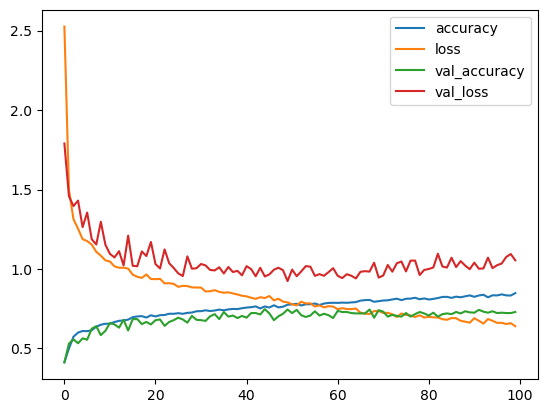

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot()
plt.show()

## Проверим точность и потери на тестовом наборе данных

In [67]:
model.evaluate(test_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7284 - loss: 1.0392


[1.0391643047332764, 0.7283653616905212]

Точность на тестовой выборке сравнима с точностью на валидационной выборке

# 2. Трансферное обучение

In [ ]:
# todo смотреть лекцию делать нейросеть